This file is to extract the training dataset from multiple files with parameters adjusted for each file separately. The code here is from the template method to extract dataset but can be replaced the gradient method as well. In the end, the extracted training dataset from all cells is combined into one big dataset.
However, this file was not used in the end. Rather an approach was taken where the extracted training dataset from each cell was scored separately and then combined. This code can be found in the file to score the dataset. 

In [1]:
import sys
sys.path.append('C:/Users/Anusha/Documents/GitHub/miniML/core/')

from miniML import MiniTrace, EventDetection
import template_matching as tm
import numpy as np
from scipy import signal
import h5py
import copy
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import matplotlib
%matplotlib inline
np.random.seed(1)

#additional packages to import
import re, struct, collections
import datetime
import os, sys
import pyqtgraph as pg
from FileImport.HekaReader import Bundle

series_data: [(array([7.82686788e-11, 7.73783745e-11, 7.57851985e-11, ...,
       7.92214606e-11, 7.97993774e-11, 7.55821466e-11]), 0.0001)]
series_resistances: [20.003667837656938]


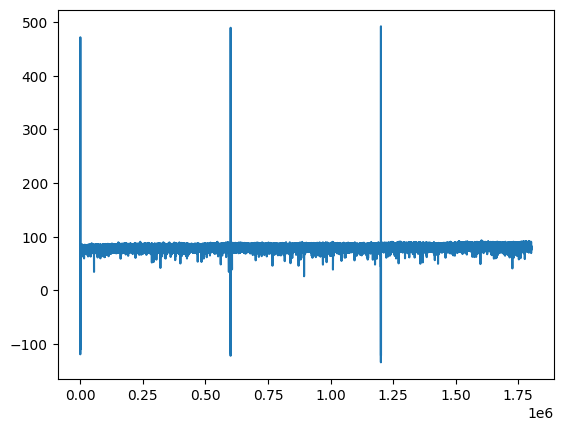

found 236 events with high threshold
235 events extracted

found 494 events with mid threshold
258 unclear events extracted

found 4248 events with low threshold
235 noise stretches extracted


In [2]:
path = 'C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/example_recordings/'
myfile = 'Melina_011124_S3_hippocampus.dat'
save_id = 'Melina_rec1'
filename = path + myfile

rectype = '1minLoop'
group = 1 #add group number (numbering starts from 1)
scaling = 1e12
unit = 'pA'
exclude_series = [3] #exclude the series in the group that is not needed (numbering starts from 0)
exclude_sweeps = {4:[]} #exclude the sweeps in the series that is not needed (numbering starts from 0)
label = 'cell1' #add name of the cell
trace = MiniTrace.from_heka_file(filename=filename,
                            group=group,
                            exclude_series = exclude_series,
                            exclude_sweeps = exclude_sweeps,
                            rectype=rectype,
                            scaling=scaling,
                            unit=unit
                            )
# getting'timestamp' of the extracted dataset not incorporated into this file since this was not used

plt.plot(trace.data)
plt.show()


# For template matching it can be useful to filter the data. We use a Hann window here.
filter_data = True
if filter_data:
    win = signal.windows.hann(15)
    tmplt_trace = signal.convolve(trace.data, win, mode='same') / sum(win)
else:
    tmplt_trace = trace.data
win_size = 350

# roughly estimate possible event shape based on window size
baseline = (win_size/8) * trace.sampling
duration = int(win_size*1/3) * trace.sampling
t_rise = (baseline+(win_size * trace.sampling))/40
t_decay = (baseline+(win_size * trace.sampling))/15

template = tm.make_template(t_rise=t_rise, t_decay=t_decay, baseline=baseline, duration=duration, sampling=trace.sampling)

cell_label, idx, events, scores = [], [], [], []

# Set the different thresholds.
threshold_high = -6.5
threshold_mid = -4.5
threshold_low = -2.5

# Run template matching with a high threshold to extract events with high confidence.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_high)
print(f'found {len(matching.indices)} events with high threshold')

event_counter = 0
for ind, location in enumerate(matching.indices):
    if location < trace.data.shape[0] - int(win_size*1.5):
        event = copy.deepcopy(trace.data[location:location+win_size])
        event -= np.mean(event[:int(win_size/10)])
        
        cell_label.append(label)
        idx.append(location)
        events.append(event)
        scores.append(1)
        event_counter += 1

print(f'{event_counter} events extracted\n')


# generate list with all indices of +/- (win_size/30) points of the previously found events to prevent duplicates (or at least keep them to a minimum)
idx_range = []
buffer = int(win_size/30)
for my_ind in idx:
    idx_range += list(range(my_ind-buffer, my_ind+buffer))

# Run tmplt matching with a relatively low threshold to extract FPs and small events.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_mid)
print(f'found {len(matching.indices)} events with mid threshold')
unclear_counter = 0
for ind, location in enumerate(matching.indices):
    if location < trace.data.shape[0] - int(win_size*1.5):
        if location not in idx_range:
            event = copy.deepcopy(trace.data[location:location+win_size])
            event -= np.mean(event[:int(win_size/10)])
            
            cell_label.append(label)
            idx.append(location)
            events.append(event)
            scores.append(2)
            unclear_counter += 1

print(f'{unclear_counter} unclear events extracted\n')
# Run tmplt matching with a very low threshold. Remaining parts of the trace should be event free.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_low)
print(f'found {len(matching.indices)} events with low threshold')

event_free_indices = []
for i in range(matching.indices.shape[0]-1):
    start = matching.indices[i] + win_size
    end = matching.indices[i+1] - win_size
    if end - start > 0:
        event_free_indices.append(np.arange(start, end))

event_free_indices = np.concatenate(event_free_indices)
unique_stretches = []
for ind, i in enumerate(event_free_indices):
    if ind==0:
        unique_stretches.append(i)
        next_possible = i+win_size
    
    if i < next_possible:
        pass
    else:
        unique_stretches.append(i)
        next_possible = i+win_size

# Extract unique stretches to prevent overlap and redundancy in the data
if len(unique_stretches) <= event_counter:
    inds = np.array(unique_stretches)
else:
    inds = np.random.choice(np.array(unique_stretches), event_counter, replace=False)

# Extract events
noise_counter = 0
for location in sorted(inds):
    event = copy.deepcopy(trace.data[location:location+win_size])
    event -= np.mean(event[:int(win_size/10)])
    cell_label.append(label)
    idx.append(location)
    events.append(event)
    scores.append(0)
    noise_counter += 1

print(f'{noise_counter} noise stretches extracted')
# Save the result
x = np.array(events)
y = np.array(scores)
indices = np.array(idx)

save_dataset = f'C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/output/trace1.h5'

if save_dataset:
    with h5py.File(save_dataset, 'w') as f:
        f.create_dataset("events", data=x)
        f.create_dataset("scores", data=y)
        f.create_dataset("raw_indices", data=indices)
        f.create_dataset("cell_label", data=np.array(cell_label, dtype='S'))

series_data: [(array([5.83539793e-12, 4.94196976e-12, 3.53622615e-12, ...,
       2.46848578e-11, 2.45723983e-11, 2.41100649e-11]), 0.0001)]
series_resistances: [20.003667837656938]


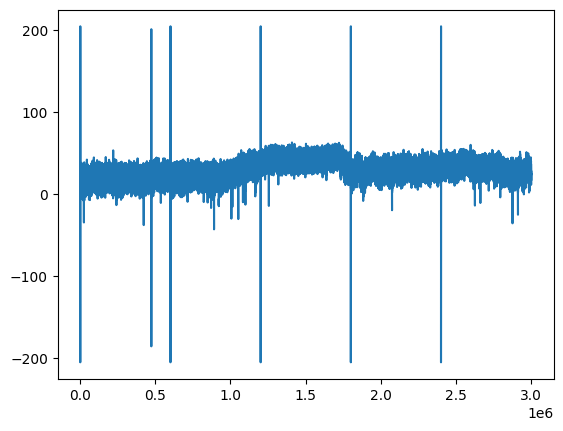

found 101 events with high threshold
101 events extracted

found 642 events with mid threshold
541 unclear events extracted

found 5372 events with low threshold
101 noise stretches extracted


In [3]:
#repeat the process to extract training dataset from another recording with the adjusted parameters and save it too
path = 'C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/example_recordings/'
myfile = 'Melina_040524_S3_hippocampus_LAA_NMDA.dat'
save_id = 'Melina_rec2'
filename = path + myfile

rectype = '1minLoop'
group = 4
scaling = 1e12
unit = 'pA'
exclude_series = [3]
exclude_sweeps = {10:[]}
label = 'cell2'
trace = MiniTrace.from_heka_file(filename=filename,
                            group=group,
                            exclude_series = exclude_series,
                            exclude_sweeps = exclude_sweeps,
                            rectype=rectype,
                            scaling=scaling,
                            unit=unit)


plt.plot(trace.data)
plt.show()


# For template matching it can be useful to filter the data. We use a Hann window here.
filter_data = True
if filter_data:
    win = signal.windows.hann(15)
    tmplt_trace = signal.convolve(trace.data, win, mode='same') / sum(win)
else:
    tmplt_trace = trace.data
win_size = 350

# roughly estimate possible event shape based on window size
baseline = (win_size/10) * trace.sampling
duration = int(win_size*2/3) * trace.sampling
t_rise = (baseline+(win_size * trace.sampling))/13
t_decay = (baseline+(win_size * trace.sampling))/7

template = tm.make_template(t_rise=t_rise, t_decay=t_decay, baseline=baseline, duration=duration, sampling=trace.sampling)

cell_label, idx, events, scores = [], [], [], []

# Set the different thresholds.
threshold_high = -6.5
threshold_mid = -5.0
threshold_low = -3.0

# Run template matching with a high threshold to extract events with high confidence.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_high)
print(f'found {len(matching.indices)} events with high threshold')

event_counter = 0
for ind, location in enumerate(matching.indices):
    if location < trace.data.shape[0] - int(win_size*1.5):
        event = copy.deepcopy(trace.data[location:location+win_size])
        event -= np.mean(event[:int(win_size/10)])
        
        cell_label.append(label)
        idx.append(location)
        events.append(event)
        scores.append(1)
        event_counter += 1

print(f'{event_counter} events extracted\n')


# generate list with all indices of +/- (win_size/30) points of the previously found events to prevent duplicates (or at least keep them to a minimum)
idx_range = []
buffer = int(win_size/30)
for my_ind in idx:
    idx_range += list(range(my_ind-buffer, my_ind+buffer))

# Run tmplt matching with a relatively low threshold to extract FPs and small events.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_mid)
print(f'found {len(matching.indices)} events with mid threshold')
unclear_counter = 0
for ind, location in enumerate(matching.indices):
    if location < trace.data.shape[0] - int(win_size*1.5):
        if location not in idx_range:
            event = copy.deepcopy(trace.data[location:location+win_size])
            event -= np.mean(event[:int(win_size/10)])
            
            cell_label.append(label)
            idx.append(location)
            events.append(event)
            scores.append(2)
            unclear_counter += 1

print(f'{unclear_counter} unclear events extracted\n')
# Run tmplt matching with a very low threshold. Remaining parts of the trace should be event free.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_low)
print(f'found {len(matching.indices)} events with low threshold')

event_free_indices = []
for i in range(matching.indices.shape[0]-1):
    start = matching.indices[i] + win_size
    end = matching.indices[i+1] - win_size
    if end - start > 0:
        event_free_indices.append(np.arange(start, end))

event_free_indices = np.concatenate(event_free_indices)
unique_stretches = []
for ind, i in enumerate(event_free_indices):
    if ind==0:
        unique_stretches.append(i)
        next_possible = i+win_size
    
    if i < next_possible:
        pass
    else:
        unique_stretches.append(i)
        next_possible = i+win_size

# Extract unique stretches to prevent overlap and redundancy in the data
if len(unique_stretches) <= event_counter:
    inds = np.array(unique_stretches)
else:
    inds = np.random.choice(np.array(unique_stretches), event_counter, replace=False)

# Extract events
noise_counter = 0
for location in sorted(inds):
    event = copy.deepcopy(trace.data[location:location+win_size])
    event -= np.mean(event[:int(win_size/10)])
    cell_label.append(label)
    idx.append(location)
    events.append(event)
    scores.append(0)
    noise_counter += 1

print(f'{noise_counter} noise stretches extracted')
# Save the result
x = np.array(events)
y = np.array(scores)
indices = np.array(idx)

save_dataset = f'C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/output/trace2.h5'

if save_dataset:
    with h5py.File(save_dataset, 'w') as f:
        f.create_dataset("events", data=x)
        f.create_dataset("scores", data=y)
        f.create_dataset("raw_indices", data=indices)
        f.create_dataset("cell_label", data=np.array(cell_label, dtype='S'))

In [4]:
# Combine the extracted training datasets from all cells
def combine_datasets(file_list, output_file):
    combined_events = []
    combined_scores = []
    combined_indices = []
    combined_labels = []

    for file in file_list:
        with h5py.File(file, 'r') as f:
            combined_events.append(f['events'][:])
            combined_scores.append(f['scores'][:])
            combined_indices.append(f['raw_indices'][:])
            combined_labels.append(f['cell_label'][:])

    combined_events = np.concatenate(combined_events, axis=0)
    combined_scores = np.concatenate(combined_scores, axis=0)
    combined_indices = np.concatenate(combined_indices, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    with h5py.File(output_file, 'w') as f:
        f.create_dataset("events", data=combined_events)
        f.create_dataset("scores", data=combined_scores)
        f.create_dataset("raw_indices", data=combined_indices)
        f.create_dataset("cell_label", data=combined_labels)

    print(f'Combined data saved to {output_file}')

# File paths of the individual datasets
file_list = [
    'C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/output/trace1.h5',
    'C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/output/trace2.h5'
]

# Output file path for the combined dataset
output_file = 'C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/output/combined_training_data1.h5'

# Combine the datasets
combine_datasets(file_list, output_file)


Combined data saved to C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/output/combined_training_data1.h5
